<h1>Generating training data for XGBoost</h1>

In [1]:
import sys
sys.path.append("/home/ross/CytoPy")

In [2]:
from CytoPy.data.project import Project
from CytoPy.data.population import Population
from CytoPy.data.setup import global_init
from CytoPy.data.gating_strategy import *
from CytoPy.flow.cell_classifier import SklearnCellClassifier
from CytoPy.flow.ref import create_ref_sample
global_init("Peritonitis")

In [3]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import pandas as pd
import numpy as np
import logging
sns.set(style="white", font_scale=1.3)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [4]:
project = Project.objects(project_id="Immunofingerprints").get()
project.list_experiments()

['Drain fluid T cells',
 'Drain fluid Leukocytes',
 'Corrected drain fluid T cells',
 'Corrected drain fluid Leukocytes']

In [5]:
exp = project.load_experiment("Corrected drain fluid T cells")

<h2>Generate training data</h2>

In [11]:
create_ref_sample(experiment=exp, sample_size=5000, root_population="root",
                  new_file_name="Training Data")

  0%|          | 0/44 [00:00<?, ?it/s]

/home/ross/CytoPy/CytoPy/flow/sampling.py:74: UserWarning: Number of observations larger than requested sample size 5000, returning complete data (n=512)
  warn(f"Number of observations larger than requested sample size {sample_size}, "
/home/ross/CytoPy/CytoPy/flow/sampling.py:74: UserWarning: Number of observations larger than requested sample size 5000, returning complete data (n=4205)
  warn(f"Number of observations larger than requested sample size {sample_size}, "
/home/ross/CytoPy/CytoPy/flow/sampling.py:74: UserWarning: Number of observations larger than requested sample size 5000, returning complete data (n=1913)
  warn(f"Number of observations larger than requested sample size {sample_size}, "
/home/ross/CytoPy/CytoPy/flow/sampling.py:74: UserWarning: Number of observations larger than requested sample size 5000, returning complete data (n=611)
  warn(f"Number of observations larger than requested sample size {sample_size}, "
/home/ross/CytoPy/CytoPy/flow/sampling.py:74: User

<h2>T cells</h2>

In [12]:
gates = GatingStrategy(name="T cell labels")

In [13]:
gates.load_data(exp, "Training Data")

<AxesSubplot:xlabel='PanGD', ylabel='Vd2'>

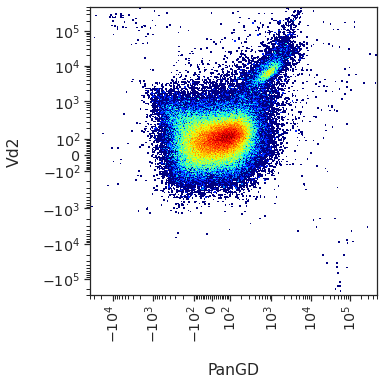

In [14]:
gates.plot_population("root", "PanGD", "Vd2", transform_x="logicle", transform_y="logicle")

<AxesSubplot:xlabel='PanGD', ylabel='Vd2'>

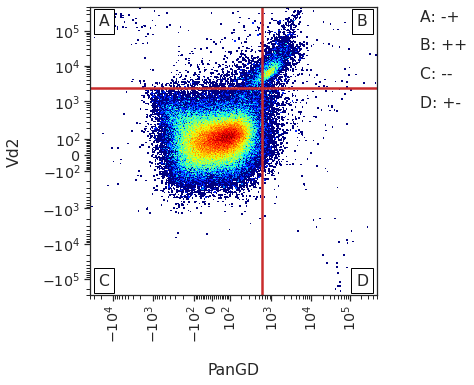

In [23]:
gdt_gate = ThresholdGate(gate_name="GDTGate",
                         parent="root",
                         x="PanGD",
                         y="Vd2",
                         transform_x="logicle",
                         transform_y="logicle",
                         method="density")
gates.preview_gate(gdt_gate)

----- ManualGDTGate -----
Parent (root) n: 202183
...child GDTs n: 10156; 5.0231720767819255% of parent
...child Not GDTs n: 192027; 94.97682792321808% of parent
------------------------


<AxesSubplot:xlabel='PanGD', ylabel='Vd2'>

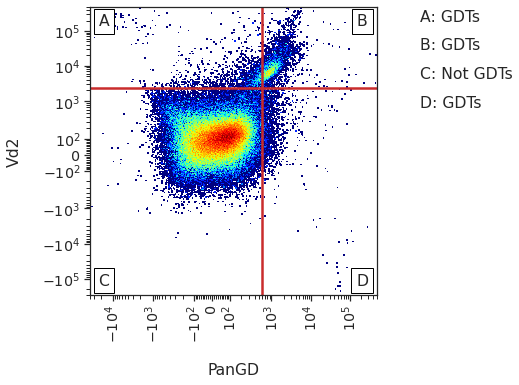

In [24]:
gdt_gate.label_children({"-+": "GDTs",
                         "+-": "GDTs",
                         "++": "GDTs",
                         "--": "Not GDTs"})
gates.apply_gate(gdt_gate)

<AxesSubplot:xlabel='PanGD', ylabel='Vd2'>

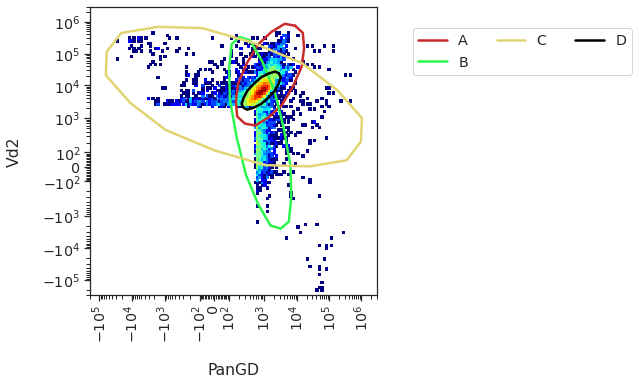

In [27]:
gdt_gate = EllipseGate(gate_name="Vd2GDTGate",
                       parent="GDTs",
                       x="PanGD",
                       y="Vd2",
                       transform_x="logicle",
                       transform_y="logicle",
                       method="GaussianMixture",
                       method_kwargs={"n_components": 4, "conf": 0.99})
gates.preview_gate(gdt_gate)

----- Vd2GDTGate -----
Parent (GDTs) n: 10156
...child Vd2+ GDTs n: 8252; 81.25246159905475% of parent
------------------------


<AxesSubplot:xlabel='PanGD', ylabel='Vd2'>

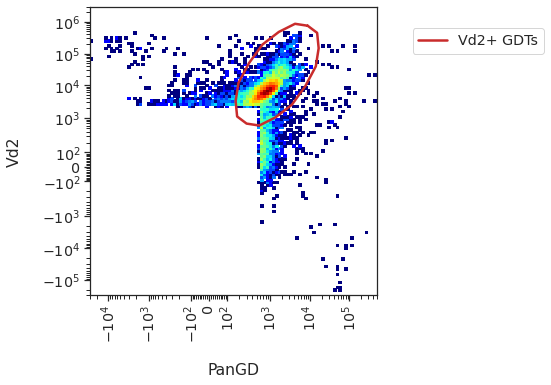

In [28]:
gdt_gate.label_children({"A": "Vd2+ GDTs"})
gates.apply_gate(gdt_gate)

<AxesSubplot:xlabel='CD161', ylabel='Va7-2'>

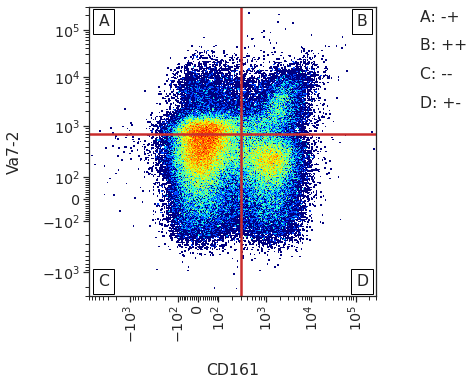

In [32]:
mait_gate = ThresholdGate(gate_name="MAITGate",
                         parent="Not GDTs",
                         x="CD161",
                         y="Va7-2",
                         transform_x="logicle",
                         transform_y="logicle",
                         method="manual",
                         method_kwargs={"x_threshold": 300, "y_threshold": 700})
gates.preview_gate(mait_gate)

----- MAITGate -----
Parent (Not GDTs) n: 192027
...child MAIT cells n: 17887; 9.31483593453004% of parent
...child Classic T cells n: 174140; 90.68516406546996% of parent
------------------------


<AxesSubplot:xlabel='CD161', ylabel='Va7-2'>

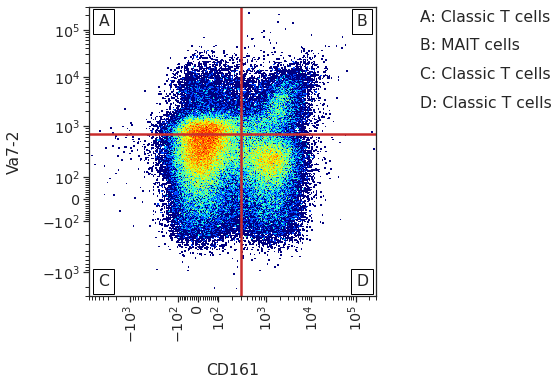

In [33]:
mait_gate.label_children({"-+": "Classic T cells",
                         "+-": "Classic T cells",
                         "++": "MAIT cells",
                         "--": "Classic T cells"})
gates.apply_gate(mait_gate)

<AxesSubplot:xlabel='CD4', ylabel='CD8'>

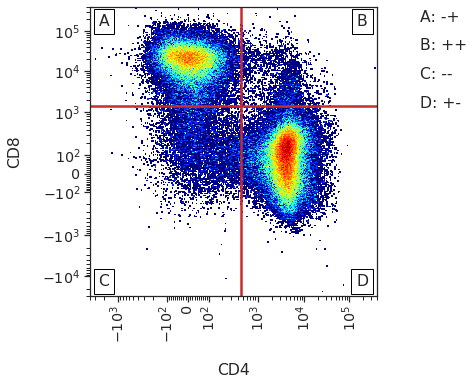

In [39]:
cd4cd8_gate = ThresholdGate(gate_name="CD4CD8Gate",
                            parent="Classic T cells",
                            x="CD4",
                            y="CD8",
                            transform_x="logicle",
                            transform_y="logicle",
                            method="density")
gates.preview_gate(cd4cd8_gate)

----- CD4CD8Gate -----
Parent (Classic T cells) n: 174140
...child CD4+ T cells n: 106526; 61.17261973125072% of parent
...child CD8+ T cells n: 57485; 33.010795911335705% of parent
------------------------


<AxesSubplot:xlabel='CD4', ylabel='CD8'>

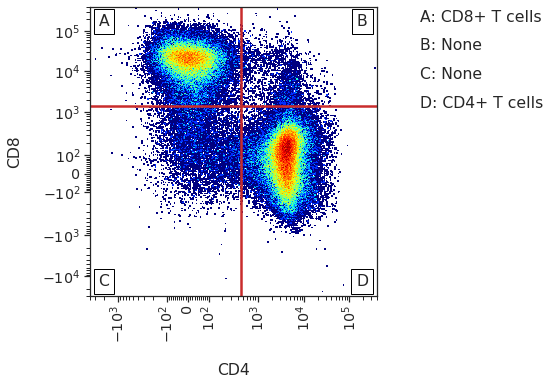

In [40]:
cd4cd8_gate.label_children({"-+": "CD8+ T cells",
                            "+-": "CD4+ T cells"})
gates.apply_gate(cd4cd8_gate)

In [51]:
gates.save()

<h2>Leukocytes</h2>

In [6]:
exp = project.load_experiment("Corrected drain fluid Leukocytes")

In [6]:
create_ref_sample(experiment=exp, sample_size=5000, root_population="root",
                  new_file_name="Training Data")

  0%|          | 0/47 [00:00<?, ?it/s]

/home/ross/CytoPy/CytoPy/flow/sampling.py:74: UserWarning: Number of observations larger than requested sample size 5000, returning complete data (n=2168)
  warn(f"Number of observations larger than requested sample size {sample_size}, "


In [7]:
gates = GatingStrategy(name="Leukocyte labels")

In [8]:
gates.load_data(exp, "Training Data")

<AxesSubplot:xlabel='CD116', ylabel='CD15'>

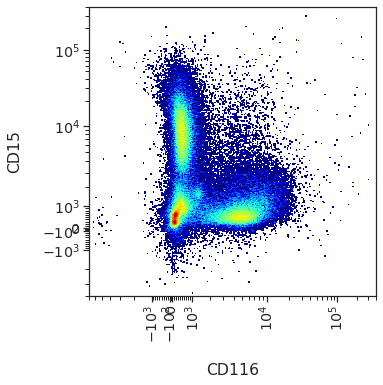

In [10]:
kwargs = dict(w=1.0, m=4)
pkwargs = dict(transform_x_kwargs=kwargs, transform_y_kwargs=kwargs)
gates.plot_population("root", "CD116", "CD15", create_plot_kwargs=pkwargs)

<AxesSubplot:xlabel='CD116', ylabel='CD15'>

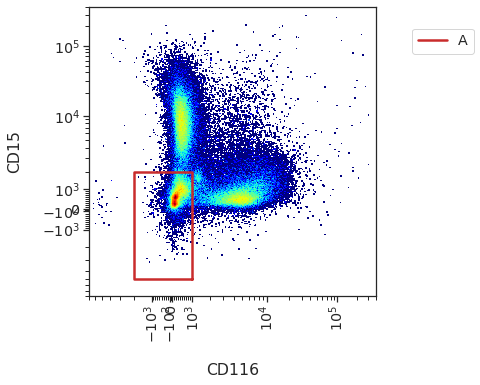

In [11]:
CD116PGate = PolygonGate(gate_name="CD116PGate",
                        parent="root",
                        x="CD116",
                        y="CD15",
                        transform_x="logicle",
                        transform_y="logicle",
                        transform_x_kwargs=kwargs,
                        transform_y_kwargs=kwargs,
                        method="manual",
                        method_kwargs={"x_values": [1000, 1000, -2000, -2000, 1000],
                                       "y_values": [-5000, 2000, 2000, -5000, -5000]})
gates.preview_gate(CD116PGate)

In [12]:
CD116PGate.label_children({"A": "CD116-"})
gates.apply_gate(CD116PGate, plot=False)

----- CD116PGate -----
Parent (root) n: 232168
...child CD116- n: 78071; 33.6269425588367% of parent
------------------------


<AxesSubplot:xlabel='CD116', ylabel='CD15'>

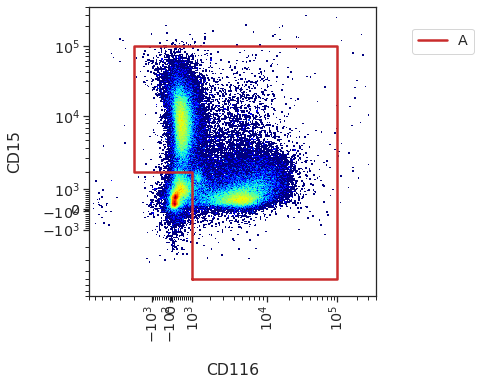

In [13]:
x = [1001, 100000, 100000, -2001, -2001, 1001, 1001]
y = [-5000, -5000, 100000, 100000, 2001, 2001, -5000]
CD116NGate = PolygonGate(gate_name="CD116NGate",
                        parent="root",
                        x="CD116",
                        y="CD15",
                        transform_x="logicle",
                        transform_y="logicle",
                        transform_x_kwargs=kwargs,
                        transform_y_kwargs=kwargs,
                        method="manual",
                        method_kwargs={"x_values": x,
                                       "y_values": y})
gates.preview_gate(CD116NGate)

In [14]:
CD116NGate.label_children({"A": "CD116+"})
gates.apply_gate(CD116NGate, plot=False)

----- CD116NGate -----
Parent (root) n: 232168
...child CD116+ n: 153974; 66.32007856379862% of parent
------------------------


<AxesSubplot:xlabel='CD3', ylabel='CD19'>

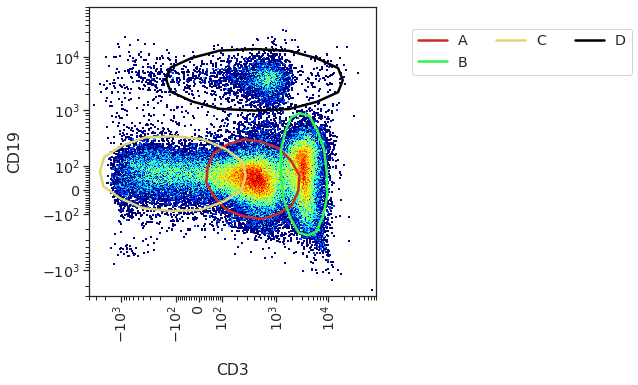

In [15]:
cd3cd19_gate = EllipseGate(gate_name="CD3CD19Gate",
                           parent="CD116-",
                           x="CD3",
                           y="CD19",
                           transform_x="logicle",
                           transform_y="logicle",
                           method="GaussianMixture",
                           method_kwargs={"n_components": 4, 
                                            "conf": 0.95})
gates.preview_gate(cd3cd19_gate)

In [16]:
cd3cd19_gate.label_children({"B": "CD3+ CD19-",
                             "D": "CD3- CD19+"})
gates.apply_gate(cd3cd19_gate, plot=False)

----- CD3CD19Gate -----
Parent (CD116-) n: 78071
...child CD3+ CD19- n: 22970; 29.421936442469033% of parent
...child CD3- CD19+ n: 3938; 5.044126500236964% of parent
------------------------


<AxesSubplot:xlabel='FSC-A', ylabel='SSC-A'>

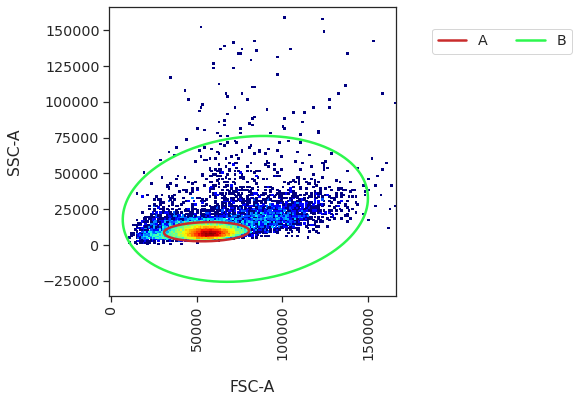

In [21]:
tcell_gate = EllipseGate(gate_name="TcellGate",
                         parent="CD3+ CD19-",
                         x="FSC-A",
                         y="SSC-A",
                         transform_x=None,
                         transform_y=None,
                         method="GaussianMixture",
                         method_kwargs={"n_components": 2})
gates.preview_gate(tcell_gate)

----- TcellGate -----
Parent (CD3+ CD19-) n: 22970
...child T cells n: 18809; 81.88506747932085% of parent
------------------------


<AxesSubplot:xlabel='FSC-A', ylabel='SSC-A'>

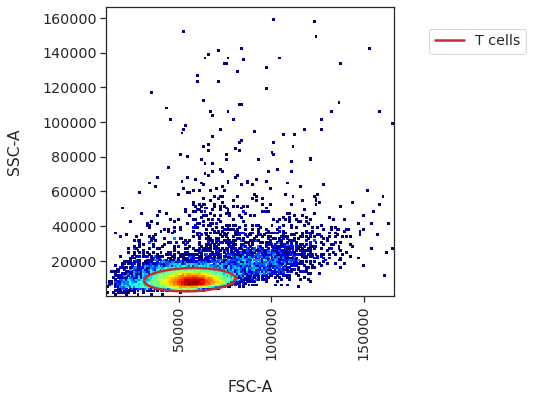

In [22]:
tcell_gate.label_children({"A": "T cells"})
gates.apply_gate(tcell_gate)

<AxesSubplot:xlabel='FSC-A', ylabel='SSC-A'>

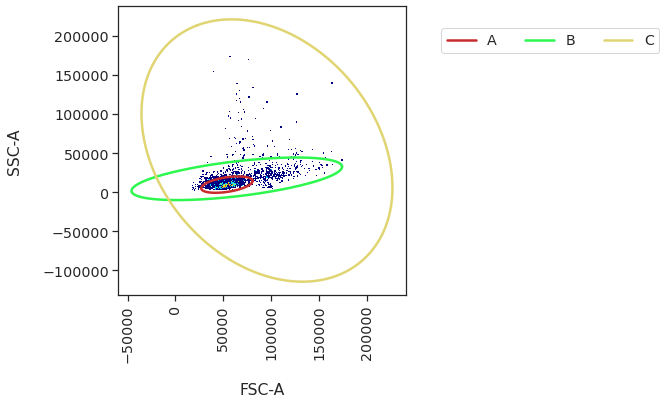

In [23]:
bcell_gate = EllipseGate(gate_name="BcellGate",
                         parent="CD3- CD19+",
                         x="FSC-A",
                         y="SSC-A",
                         transform_x=None,
                         transform_y=None,
                         method="GaussianMixture",
                         method_kwargs={"n_components": 3, "conf": 0.9999})
gates.preview_gate(bcell_gate, create_plot_kwargs={"bins": 500})

----- BcellGate -----
Parent (CD3- CD19+) n: 3938
...child B cells n: 3282; 83.34179786693753% of parent
------------------------


<AxesSubplot:xlabel='FSC-A', ylabel='SSC-A'>

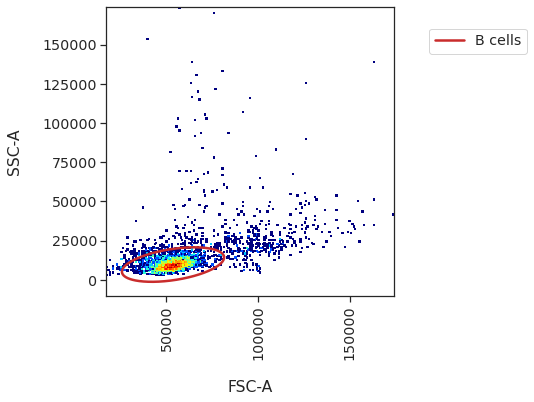

In [24]:
bcell_gate.label_children({"A": "B cells"})
gates.apply_gate(bcell_gate, create_plot_kwargs={"bins": 200})

<AxesSubplot:xlabel='CD15', ylabel='Siglec8'>

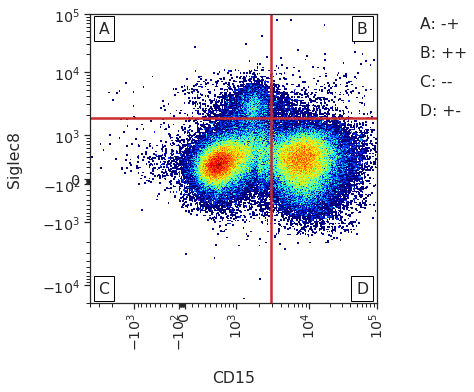

In [25]:
tkwargs = dict(w=0.5, m=3.8)
CD15Siglec8 = ThresholdGate(gate_name="CD15Siglec8",
                          parent="CD116+",
                          x="CD15",
                          y="Siglec8",
                          transform_x="logicle",
                          transform_y="logicle",
                          transform_x_kwargs=tkwargs,
                          transform_y_kwargs=tkwargs,
                          method="density")
gates.preview_gate(CD15Siglec8)

In [26]:
CD15Siglec8.label_children({"-+": "CD15- Siglec8+",
                            "--": "CD15- Siglec8-",
                            "+-": "CD15+ Siglec8-"})
gates.apply_gate(CD15Siglec8, plot=False)

----- CD15Siglec8 -----
Parent (CD116+) n: 153974
...child CD15- Siglec8- n: 75184; 48.82902308181901% of parent
...child CD15+ Siglec8- n: 72835; 47.30344084066141% of parent
...child CD15- Siglec8+ n: 4882; 3.1706651772377157% of parent
------------------------


<AxesSubplot:xlabel='FSC-A', ylabel='SSC-A'>

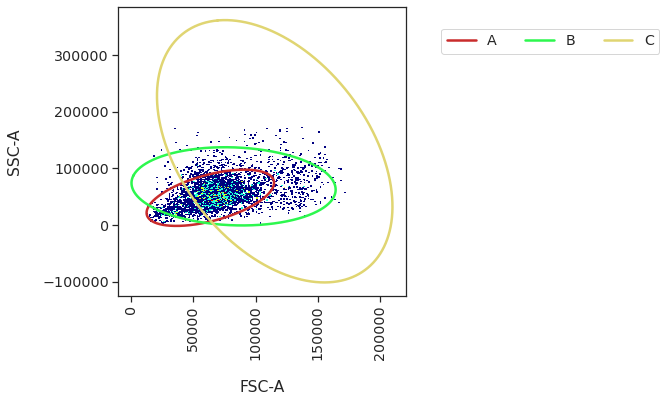

In [27]:
EosinoGate = EllipseGate(gate_name="EosinoGate",
                          parent="CD15- Siglec8+",
                          x="FSC-A",
                          y="SSC-A",
                          transform_x=None,
                          transform_y=None,
                          method="GaussianMixture",
                          method_kwargs={"n_components": 3, "conf": 0.99})
gates.preview_gate(EosinoGate, create_plot_kwargs=dict(bins=250))

In [28]:
EosinoGate.label_children({"A": "Eosinophils"})
gates.apply_gate(EosinoGate, plot=False)

----- EosinoGate -----
Parent (CD15- Siglec8+) n: 4882
...child Eosinophils n: 3749; 76.79229823842687% of parent
------------------------


<AxesSubplot:xlabel='FSC-A', ylabel='SSC-A'>

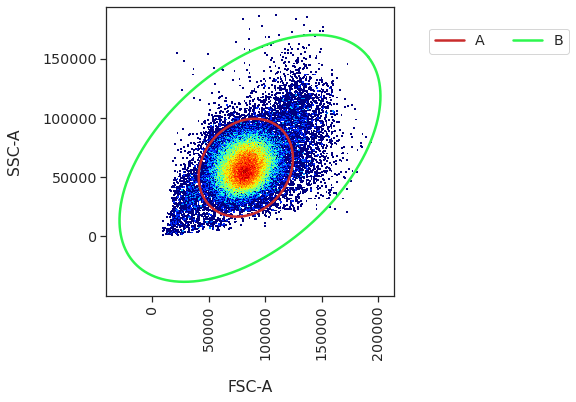

In [29]:
NeutroGate = EllipseGate(gate_name="NeutroGate",
                          parent="CD15+ Siglec8-",
                          x="FSC-A",
                          y="SSC-A",
                          transform_x=None,
                          transform_y=None,
                          method="GaussianMixture",
                          method_kwargs={"n_components": 2, "conf": 0.999})
gates.preview_gate(NeutroGate, create_plot_kwargs=dict(bins=250))

In [30]:
NeutroGate.label_children({"A": "Neutrophils"})
gates.apply_gate(NeutroGate, plot=False)

----- NeutroGate -----
Parent (CD15+ Siglec8-) n: 72835
...child Neutrophils n: 67592; 92.80153772224892% of parent
------------------------


<AxesSubplot:xlabel='HLA-DR', ylabel='CD14'>

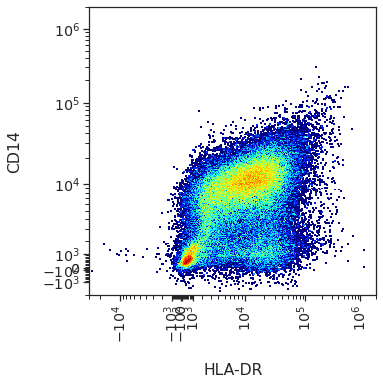

In [41]:
tkwargs = dict(w=0.8, m=3.5)
pkwargs = dict(transform_x_kwargs=tkwargs, transform_y_kwargs=tkwargs)
gates.plot_population("CD15- Siglec8-", "HLA-DR", "CD14",
                      transform_x="logicle",
                      transform_y="logicle",
                      create_plot_kwargs=pkwargs)

<AxesSubplot:xlabel='HLA-DR', ylabel='CD14'>

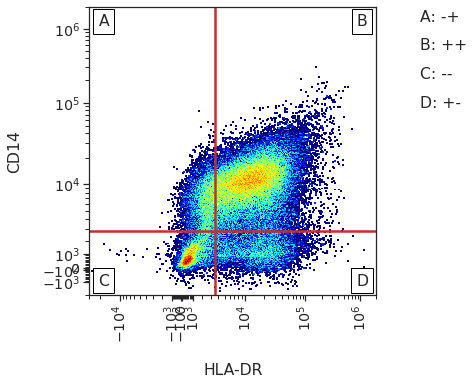

In [43]:
tkwargs = dict(w=0.8, m=3.5)
HLADR_CD14 = ThresholdGate(gate_name="HLADR_CD14",
                          parent="CD15- Siglec8-",
                          x="HLA-DR",
                          y="CD14",
                          transform_x="logicle",
                          transform_y="logicle",
                          transform_x_kwargs=tkwargs,
                          transform_y_kwargs=tkwargs,
                          method="density")
gates.preview_gate(HLADR_CD14)

In [44]:
HLADR_CD14.label_children({"+-": "macrophages/monocytes",
                            "++": "macrophages/monocytes",
                            "-+": "macrophages/monocytes"})
gates.apply_gate(HLADR_CD14, plot=False)

----- HLADR_CD14 -----
Parent (CD15- Siglec8-) n: 75184
...child macrophages/monocytes n: 65508; 87.13024047669717% of parent
------------------------


<AxesSubplot:xlabel='CD1c', ylabel='CD14'>

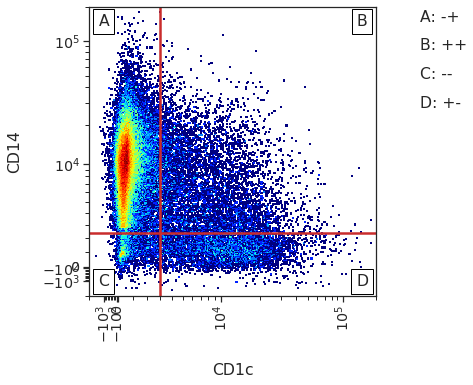

In [50]:
tkwargs = dict(w=0.7, m=3.2)
CD1c_CD14 = ThresholdGate(gate_name="CD1c_CD14",
                          parent="macrophages/monocytes",
                          x="CD1c",
                          y="CD14",
                          transform_x="logicle",
                          transform_y="logicle",
                          transform_x_kwargs=tkwargs,
                          transform_y_kwargs=tkwargs,
                          method="density")
gates.preview_gate(CD1c_CD14)

In [51]:
CD1c_CD14.label_children({"-+": "CD1c- CD14+",
                            "++": "CD1c+",
                            "+-": "CD1c+"})
gates.apply_gate(CD1c_CD14, plot=False)

----- CD1c_CD14 -----
Parent (macrophages/monocytes) n: 65508
...child CD1c+ n: 12099; 18.46949990840813% of parent
...child CD1c- CD14+ n: 50786; 77.52640898821518% of parent
------------------------


<AxesSubplot:xlabel='FSC-A', ylabel='SSC-A'>

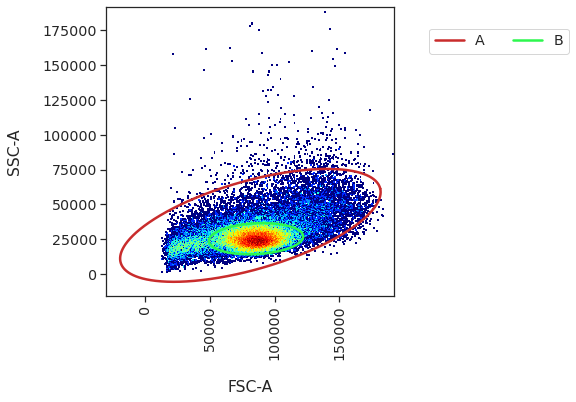

In [53]:
MonoGate = EllipseGate(gate_name="MonoGate",
                          parent="CD1c- CD14+",
                          x="FSC-A",
                          y="SSC-A",
                          transform_x=None,
                          transform_y=None,
                          method="GaussianMixture",
                          method_kwargs={"n_components": 2, "conf": 0.95})
gates.preview_gate(MonoGate, create_plot_kwargs=dict(bins=250))

In [54]:
MonoGate.label_children({"B": "Monocytes"})
gates.apply_gate(MonoGate, plot=False)

----- MonoGate -----
Parent (CD1c- CD14+) n: 50786
...child Monocytes n: 36205; 71.28933170558815% of parent
------------------------


<AxesSubplot:xlabel='FSC-A', ylabel='SSC-A'>

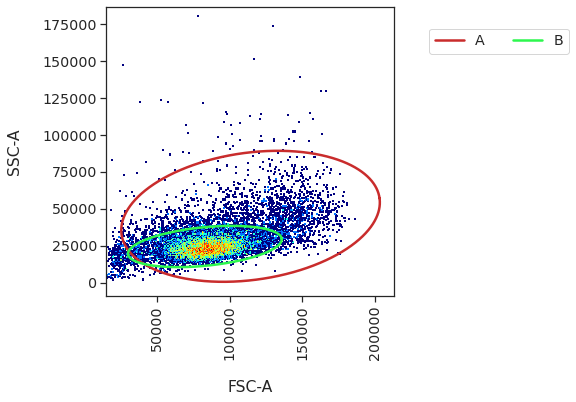

In [55]:
DCGate = EllipseGate(gate_name="DCGate",
                          parent="CD1c+",
                          x="FSC-A",
                          y="SSC-A",
                          transform_x=None,
                          transform_y=None,
                          method="GaussianMixture",
                          method_kwargs={"n_components": 2, "conf": 0.95})
gates.preview_gate(DCGate, create_plot_kwargs=dict(bins=250))

In [57]:
DCGate.label_children({"B": "DCs"})
gates.apply_gate(DCGate, plot=False)

----- DCGate -----
Parent (CD1c+) n: 12099
...child DCs n: 9711; 80.26283163897843% of parent
------------------------


In [58]:
gates.save()